In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core
%pip install openai pydantic --upgrade


In [ ]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

In [17]:
import os

os.environ["AZURE_OPENAI_ENDPOINT"] = #
os.environ["AZURE_OPENAI_API_KEY"] = #
os.environ["OPENAI_API_VERSION"] = "2025-01-01-preview"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "default"
os.environ["LANGCHAIN_API_KEY"] = #

In [19]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment="gpt-4",  # or your deployment
    #api_version="2025-01-01-preview",  # or your api version
    api_version="2024-10-21",  # or your api version
    
    temperature=0,
)

messages = [
    (
        "system",
        "You are a helpful assistant that translates English to Portuguese. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content='Eu amo programação.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 31, 'total_tokens': 36, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-00c7d89f-5fd3-44f1-a88c-40f0dcb3c0e0-0', usage_metadata={'input_tokens': 31, 'output_tokens': 5, 'total_tokens': 36, 'input_token_deta

In [4]:
ai_msg.response_metadata

{'token_usage': {'completion_tokens': 5,
  'prompt_tokens': 31,
  'total_tokens': 36,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'gpt-4',
 'system_fingerprint': None,
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'finish_reason': 'stop',
 'logprobs': None,
 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
  'self_harm': {'filtered': False, 'severity': 'safe'},
  'sexual': {'filtered': False, 'severity': 'safe'},
  'violence': {'filtered': False, 'severity': 'safe'}}}

In [ ]:
from pydantic import BaseModel
from openai import AzureOpenAI

client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
  api_version="0125-Preview"
)


In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

completion = client.chat.completions.parse(
    model="ailedautomationopenai001", # replace with the model deployment name of your gpt-4o 2024-08-06 deployment
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {"role": "user", "content": "Alice and Bob are going to a science fair on Friday."},
    ],
    response_format=SearchQuery,
)

event = completion.choices[0].message.parsed

print(event)
print(completion.model_dump_json(indent=2))

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
#print(output.search_query)
#print(output.justification)

# Prompt Chaining

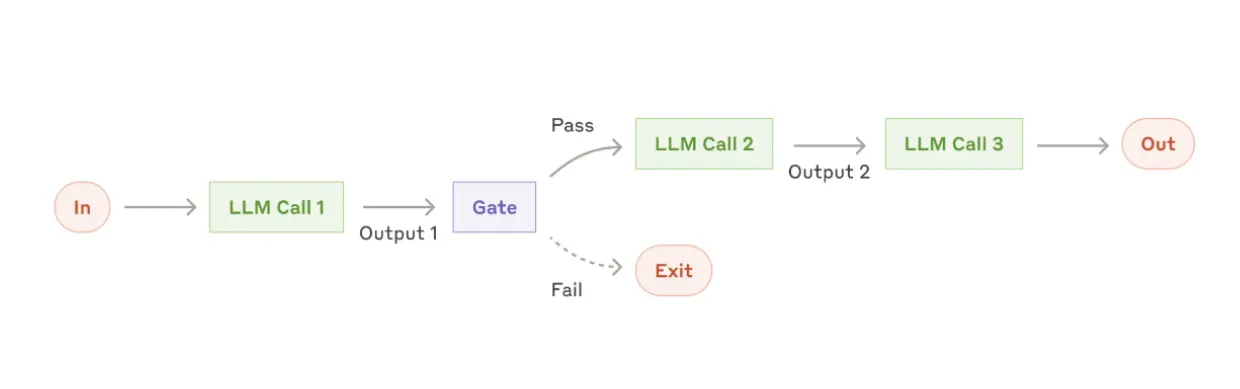

In [18]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    suggestion: str
    improved_suggestion: str
    final_suggestion: str

In [13]:
# Nodes
def generate_suggestion(state: State):
    """First LLM call to generate initial suggestion"""

    msg = llm.invoke(f"Write a short suggestion about {state['topic']}")
    return {"suggestion": msg.content}

def improve_suggestion(state: State):
    """Second LLM call to improve the suggestion"""

    msg = llm.invoke(f"Make this suggestion better by adding an senior guy review: {state['suggestion']}")
    return {"improved_suggestion": msg.content}


def generate_final_suggestion(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a additional advice which cannot be missed to this: {state['improved_suggestion']}")
    return {"final_suggestion": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the suggestion has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    #if "?" in state["suggestion"] or "!" in state["suggestion"]:
    if len(state["suggestion"]) > 200:
        return "Pass"
    return "Fail"

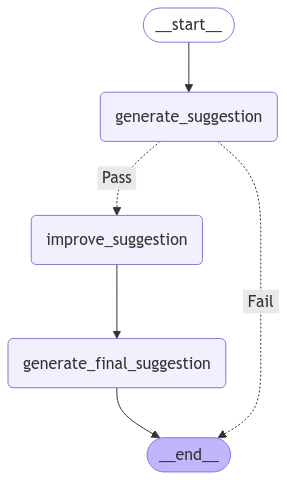

In [15]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_suggestion", generate_suggestion)
workflow.add_node("improve_suggestion", improve_suggestion)
workflow.add_node("generate_final_suggestion", generate_final_suggestion)

# Add edges to connect nodes
workflow.add_edge(START, "generate_suggestion")
workflow.add_conditional_edges(
    "generate_suggestion", check_punchline, {"Pass": "improve_suggestion", "Fail": END}
)
workflow.add_edge("improve_suggestion", "generate_final_suggestion")
workflow.add_edge("generate_final_suggestion", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [16]:
state = chain.invoke({"topic": "Mudar com minha familia do Brasil para Malta. Eu, esposa e dois filhos, um de 6 e outro de 3 anos. Ja tenho meu visto, e trabalho com um bom salario anual."})
print("Initial suggestion:")
print(state["suggestion"])
print("\n--- --- ---\n")
if "improved_suggestion" in state:
    print("Improved suggestion:")
    print(state["improved_suggestion"])
    print("\n--- --- ---\n")

    print("Final suggestion:")
    print(state["final_suggestion"])
else:
    print("Suggestion failed quality gate - no punchline detected!")

Initial suggestion:
Mudar para Malta com a sua família pode ser uma experiência incrível, já que o país é conhecido pela sua rica história, belas paisagens e qualidade de vida elevada. Aqui estão algumas sugestões:

1. Pesquise sobre a cultura e o estilo de vida em Malta para preparar sua família para a mudança. Isso inclui entender as tradições locais, a língua (inglês e maltês são as línguas oficiais) e a culinária.

2. Encontre uma casa adequada para a sua família. Considere a proximidade de escolas, supermercados e hospitais.

3. Inscreva seus filhos em uma escola. Malta tem um sistema educacional forte e muitas escolas internacionais.

4. Planeje suas finanças. Embora você tenha um bom salário, é importante considerar o custo de vida em Malta.

5. Faça um seguro de saúde. O sistema de saúde em Malta é bom, mas é sempre melhor estar preparado.

6. Finalmente, tente se envolver com a comunidade local e outras famílias brasileiras que já vivem em Malta. Eles podem oferecer conselhos 

# Parallelization

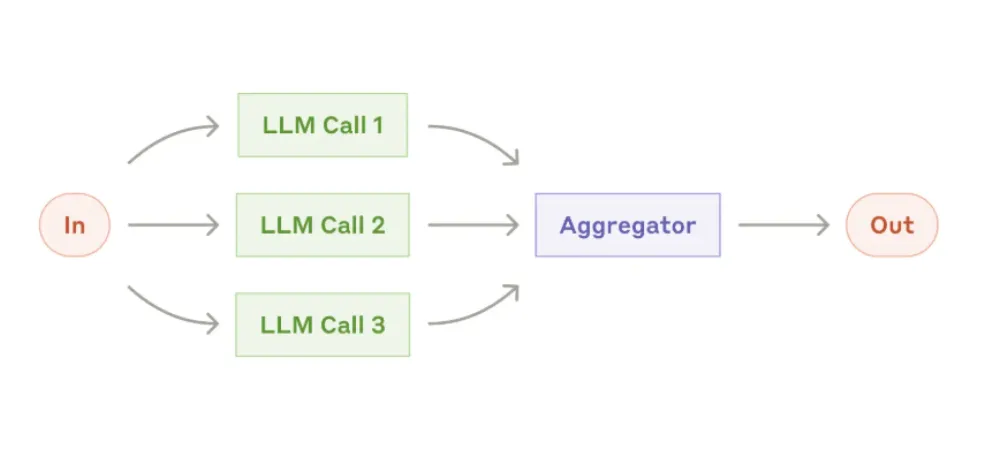

In [74]:
# Graph state
class State(TypedDict):
    topic: str
    suggestion: str
    recommendation: str
    advice: str
    combined_output: str

In [75]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial suggestion"""

    msg = llm.invoke(f"Write a suggestion about {state['topic']}")
    return {"suggestion": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate recommendation"""

    msg = llm.invoke(f"Write a recommendation about {state['topic']}")
    return {"recommendation": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate advice"""

    msg = llm.invoke(f"Write a advice about {state['topic']}")
    return {"advice": msg.content}


def aggregator(state: State):
    """Combine the suggestion, recommendation and advice into a single output"""

    combined = f"Here's a suggestion, recommendation and advice about {state['topic']}!\n\n"
    combined += f"Suggestion:\n{state['suggestion']}\n\n"
    combined += f"Recommendation:\n{state['recommendation']}\n\n"
    combined += f"Advice:\n{state['advice']}"
    return {"combined_output": combined}


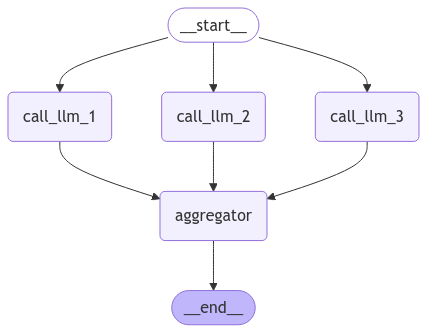

In [76]:

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [77]:
state = parallel_workflow.invoke({"topic": "Mudar com minha familia do Brasil para Malta. Eu, esposa e dois filhos, um de 6 e outro de 3 anos. Ja tenho meu visto, e trabalho com um bom salario anual."})
print(state["combined_output"])

Here's a suggestion, recommendation and advice about Mudar com minha familia do Brasil para Malta. Eu, esposa e dois filhos, um de 6 e outro de 3 anos. Ja tenho meu visto, e trabalho com um bom salario anual.!

Suggestion:
Mudar para um novo país é uma decisão importante e requer um planejamento cuidadoso. Aqui estão algumas sugestões para sua mudança do Brasil para Malta:

1. Pesquisa: Antes de se mudar, pesquise sobre Malta, sua cultura, estilo de vida, custo de vida, sistema educacional, saúde e segurança. Isso ajudará você e sua família a se adaptarem mais facilmente.

2. Acomodação: Procure uma acomodação adequada para sua família. Considere a proximidade de escolas, hospitais, supermercados e seu local de trabalho.

3. Escolas: Como você tem dois filhos pequenos, a educação deles é uma prioridade. Pesquise sobre as escolas em Malta, tanto públicas quanto privadas, e escolha a que melhor se adapta às necessidades de seus filhos.

4. Saúde: Verifique se o seu seguro de saúde cobre 

# Routing

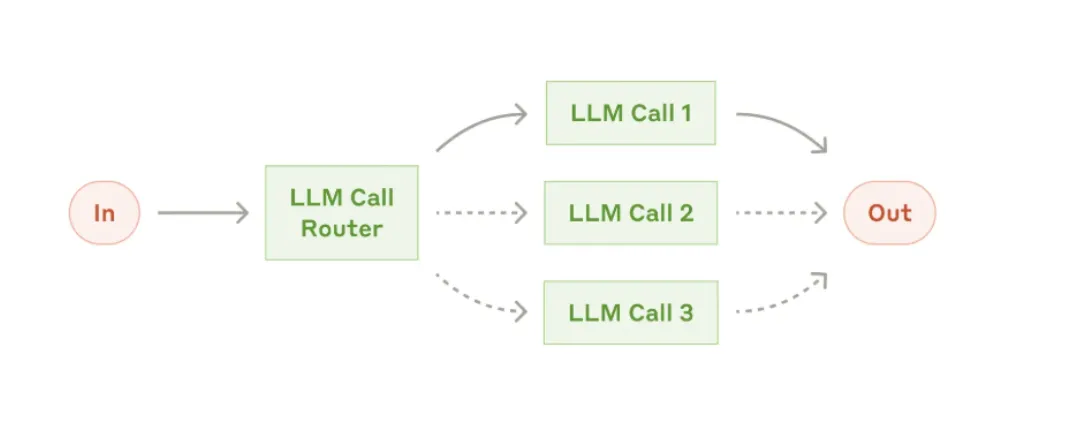

In [80]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["advice", "suggestion", "recommendation"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [81]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [82]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a advice"""

    print("Write a advice")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a suggestion"""

    print("Write a suggestion")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a recommendation"""

    print("Write a recommendation")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to advice, suggestion, or recommendation based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "advice":
        return "llm_call_1"
    elif state["decision"] == "suggestion":
        return "llm_call_2"
    elif state["decision"] == "recommendation":
        return "llm_call_3"

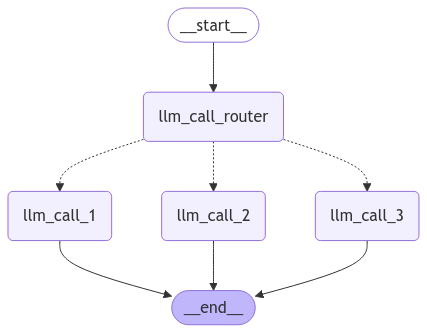

In [83]:

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [84]:
state = router_workflow.invoke({"input": "Mudar com minha familia do Brasil para Malta. Eu, esposa e dois filhos, um de 6 e outro de 3 anos. Ja tenho meu visto, e trabalho com um bom salario anual."})
print(state["output"])

BadRequestError: Error code: 400 - {'error': {'message': "'json_schema' is not one of ['json_object', 'text'] - 'response_format.type'", 'type': 'invalid_request_error', 'param': None, 'code': None}}